In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
import torchvision
import torch
from torch import nn
import zipfile
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
!pip install kaggle


!mkdir -p ~/.kaggle


!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json


!kaggle datasets list

ref                                                             title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
rabieelkharoua/students-performance-dataset                     📚 Students Performance Dataset 📚                  66KB  2024-06-12 23:09:20          11297        239  1.0              
nelgiriyewithana/most-streamed-spotify-songs-2024               Most Streamed Spotify Songs 2024                 496KB  2024-06-15 18:50:51           8651        177  1.0              
dataanalyst001/world-population-by-country-2024                 World Population by country 2024                   6KB  2024-07-04 09:47:58           1198         26  1.0              
ihelon/coffee-sales                                             Coffee Sale

In [ ]:
!kaggle datasets download -d splcher/animefacedataset

with zipfile.ZipFile("animefacedataset.zip", 'r') as zip_ref:
    zip_ref.extractall("anime_face_data")

!kaggle datasets download -d  brendanartley/cartoon-faces-googles-cartoon-set

with zipfile.ZipFile("/content/cartoon-faces-googles-cartoon-set.zip", 'r') as zip_ref:
    zip_ref.extractall("cartoon_face_data")

Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset
License(s): DbCL-1.0
 94% 370M/395M [00:07<00:00, 82.6MB/s]
100% 395M/395M [00:07<00:00, 54.8MB/s]
Dataset URL: https://www.kaggle.com/datasets/brendanartley/cartoon-faces-googles-cartoon-set
License(s): Attribution 4.0 International (CC BY 4.0)
 99% 2.32G/2.34G [00:30<00:00, 59.8MB/s]
100% 2.34G/2.34G [00:30<00:00, 82.1MB/s]


In [ ]:
images_path = '/content/anime_face_data/images'

anime_face_paths = []

for imgname in os.listdir(images_path):
  anime_face_paths.append(os.path.join(images_path,imgname))

In [ ]:
cartoon_folder_path = '/content/cartoon_face_data/cartoonset100k_jpg'

cartoon_folder_paths = []

for fname in os.listdir(cartoon_folder_path):
  cartoon_folder_paths.append(os.path.join(cartoon_folder_path,fname))
random_f = np.random.choice(len(cartoon_folder_paths), size=5, replace=False)

cartoon_face_paths = []

for r in random_f:
    images_path = cartoon_folder_paths[r]
    for imgname in os.listdir(images_path):
          cartoon_face_paths.append(os.path.join(images_path,imgname))

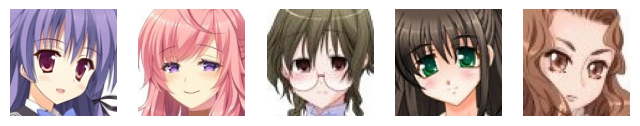

In [ ]:
figure = plt.figure(figsize=(8,7))
random_indices = np.random.choice(len(cartoon_face_paths), size=5, replace=False)
for i, r in enumerate(random_indices):
    img = tf.keras.utils.load_img(anime_face_paths[r])
    figure.add_subplot(2, 5, i+1)
    plt.axis('off')
    plt.imshow(img)
plt.show()

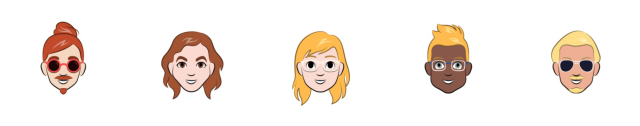

In [ ]:
figure = plt.figure(figsize=(8,7))
for i, r in enumerate(random_indices):
    img = tf.keras.utils.load_img(cartoon_face_paths[r])
    figure.add_subplot(2, 5, i+1)
    plt.axis('off')
    plt.imshow(img)
plt.show()

In [ ]:
class FaceDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image


transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

anime_dataset = FaceDataset(anime_face_paths, transform=transform)
cartoon_dataset = FaceDataset(cartoon_face_paths, transform=transform)

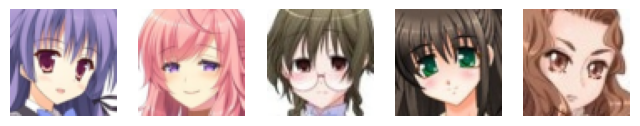

In [ ]:
figure = plt.figure(figsize=(8,7))
for i, r in enumerate(random_indices):
    img = anime_dataset.__getitem__(r).permute(1,2,0).numpy()
    figure.add_subplot(2, 5, i+1)
    plt.axis('off')
    plt.imshow(img)
plt.show()

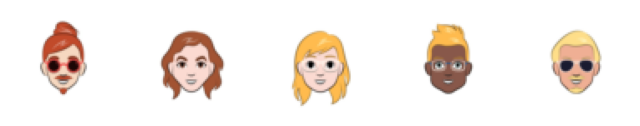

In [ ]:
figure = plt.figure(figsize=(8,7))
for i, r in enumerate(random_indices):
    img = cartoon_dataset.__getitem__(r).permute(1,2,0).numpy()
    figure.add_subplot(2, 5, i+1)
    plt.axis('off')
    plt.imshow(img)
plt.show()

# VAE


In [ ]:
class VAE(nn.Module):
  def __init__(self, n_z = 50):
    super(VAE, self).__init__()
    self.n_z = n_z
    original_dim = 64 * 64 * 3

    self.encoder_layers = torch.nn.Sequential(
      torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
      torch.nn.BatchNorm2d(16),
      torch.nn.ReLU(),
      torch.nn.MaxPool2d(kernel_size=2, stride=2),
      torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
      torch.nn.BatchNorm2d(32),
      torch.nn.ReLU(),
      torch.nn.MaxPool2d(kernel_size=2, stride=2),
      torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
      torch.nn.BatchNorm2d(64),
      torch.nn.ReLU(),
      torch.nn.MaxPool2d(kernel_size=2, stride=2),
      torch.nn.Flatten()
    )


    self.mu = nn.Linear(8*8*64, n_z)
    self.log_sigma = nn.Linear(8*8*64, n_z)

    self.decoder_layers = torch.nn.Sequential(
      torch.nn.Linear(n_z, 8*8*64),
      nn.Unflatten(1, (64, 8, 8)),
      torch.nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
      torch.nn.BatchNorm2d(32),
      torch.nn.ReLU(),
      torch.nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
      torch.nn.BatchNorm2d(16),
      torch.nn.ReLU(),
      torch.nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
      torch.nn.Sigmoid()
    )

  def encoder(self, x):
    x = self.encoder_layers(x)
    mu = self.mu(x)
    log_sigma = self.log_sigma(x)

    return mu, log_sigma

  def decoder(self, z):
    x = self.decoder_layers(z)

    return x

  def sample_z(self, mu, log_sigma):
    std = torch.exp(0.5 * log_sigma)
    eps = torch.randn_like(std)
    z = mu + eps * std

    return z
  def forward(self, x):
    # Q(z|x) --encoder
    mu, log_sigma = self.encoder(x)
    # Sample z~Q(z|x)
    z = self.sample_z(mu, log_sigma)
    # P(X|z) --decoder
    output = self.decoder(z)

    return output , mu, log_sigma

In [ ]:
def VAE_loss(output, x, mu, log_sigma):
    recon = nn.BCELoss(reduction='sum')(output.reshape((output.shape[0], 64*64*3)), x.reshape((x.shape[0], 64*64*3)))
    kl = 0.5 * torch.sum(log_sigma.exp() + mu.pow(2) - 1 - log_sigma)
    return recon + kl , recon
loss_func = nn.CrossEntropyLoss()



def learn_one_step(model, optimizer, data, device):
      data = data.to(device)
      output, mu, log_sigma = model(data)
      loss , recon= VAE_loss(output, data, mu, log_sigma)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      return  loss.item() , recon.item()


def VAE_train(dataset, model, n_epoch = 10, m = 32):
    history_loss=[]
    history_recon = []
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters())
    dataloader = DataLoader(dataset, batch_size=m, shuffle=True)
    for epoch in range(n_epoch):
          print(f'Epoch {epoch+1}')



          batch_losses, batch_recons=[], []
          model.train()
          for i, data in enumerate(tqdm(dataloader)):

              batch_loss, batch_recon = learn_one_step(model, optimizer, data, device)
              batch_losses.append(batch_loss)
              batch_recons.append(batch_recon)
          recon = torch.mean(torch.tensor(batch_recon))
          loss = torch.mean(torch.tensor(batch_losses))
          history_loss.append(loss)
          history_recon.append(recon)

          print('loss: {loss:.4f}'.format(loss=loss))
          model.eval()
    return history_loss , history_recon

In [ ]:
model = VAE()
loss , recon = VAE_train(anime_dataset, model)

Epoch 1


100%|██████████| 1987/1987 [01:22<00:00, 24.14it/s]


loss: 213613.5469
Epoch 2


100%|██████████| 1987/1987 [00:56<00:00, 35.18it/s]


loss: 209642.7812
Epoch 3


100%|██████████| 1987/1987 [00:57<00:00, 34.86it/s]


loss: 209168.2500
Epoch 4


100%|██████████| 1987/1987 [00:55<00:00, 35.76it/s]


loss: 208851.0000
Epoch 5


100%|██████████| 1987/1987 [00:56<00:00, 34.93it/s]


loss: 208532.1250
Epoch 6


100%|██████████| 1987/1987 [00:55<00:00, 35.86it/s]


loss: 208037.1094
Epoch 7


100%|██████████| 1987/1987 [00:56<00:00, 35.40it/s]


loss: 207849.5625
Epoch 8


100%|██████████| 1987/1987 [00:56<00:00, 35.15it/s]


loss: 207730.2188
Epoch 9


100%|██████████| 1987/1987 [00:56<00:00, 35.41it/s]


loss: 207635.0156
Epoch 10


100%|██████████| 1987/1987 [00:56<00:00, 34.91it/s]

loss: 207561.2344


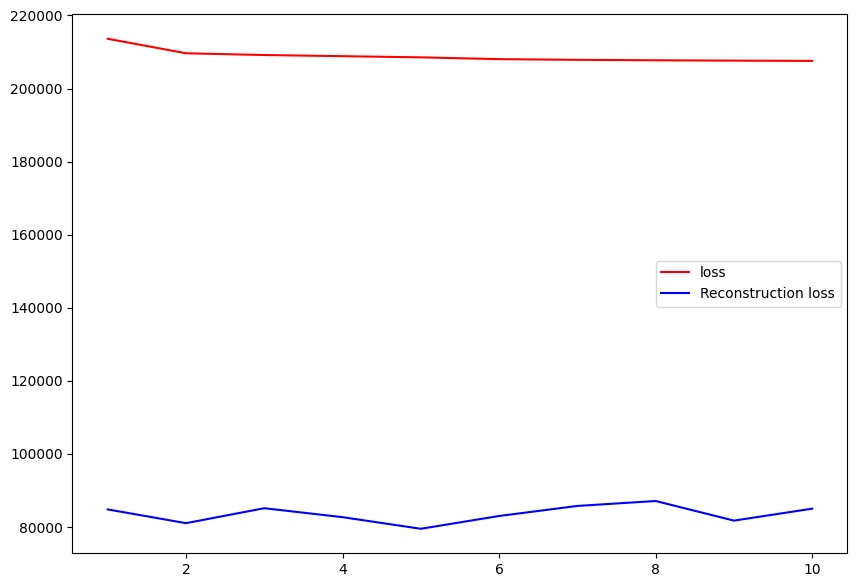

In [ ]:
n_epoch= range(1, len(loss) + 1)

figure = plt.figure(figsize=(10,7))



plt.plot(n_epoch, loss, label='loss', c='red')
plt.plot(n_epoch, recon, label='Reconstruction loss', c='blue')
plt.legend()

plt.show()

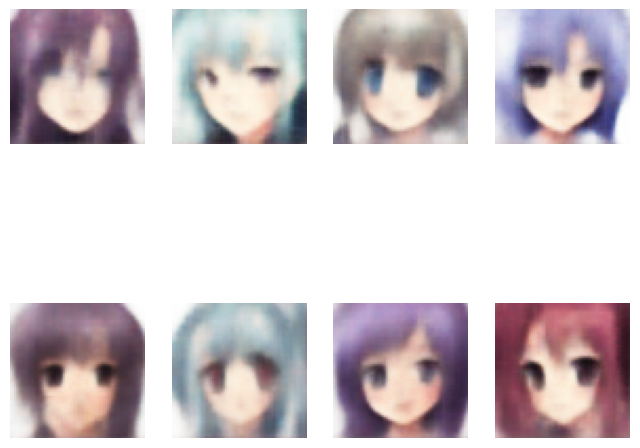

In [ ]:
def generate_new_images(model, n_face):
    model.eval()
    with torch.no_grad():
        z = torch.randn(n_face, 50).to(device)
        generated_images = model.decoder(z)


        return generated_images.cpu().numpy()

new_anime_faces = generate_new_images(model, 8)

figure = plt.figure(figsize=(8,7))
for i  in range(len(new_anime_faces)):
    figure.add_subplot(2, 4, i+1)
    plt.axis('off')
    plt.imshow(new_anime_faces[i].transpose(1, 2, 0))
plt.show()

In [ ]:
model = VAE()
loss , recon = VAE_train(cartoon_dataset, model)

Epoch 1


100%|██████████| 1563/1563 [02:37<00:00,  9.94it/s]


loss: 75114.1406
Epoch 2


100%|██████████| 1563/1563 [02:27<00:00, 10.61it/s]


loss: 58895.4727
Epoch 3


100%|██████████| 1563/1563 [02:24<00:00, 10.79it/s]


loss: 57999.4219
Epoch 4


100%|██████████| 1563/1563 [02:27<00:00, 10.60it/s]


loss: 57656.2109
Epoch 5


100%|██████████| 1563/1563 [02:26<00:00, 10.68it/s]


loss: 57467.3867
Epoch 6


100%|██████████| 1563/1563 [02:27<00:00, 10.60it/s]


loss: 57343.2305
Epoch 7


100%|██████████| 1563/1563 [02:27<00:00, 10.59it/s]


loss: 57245.1523
Epoch 8


100%|██████████| 1563/1563 [02:33<00:00, 10.20it/s]


loss: 57174.3477
Epoch 9


100%|██████████| 1563/1563 [02:26<00:00, 10.67it/s]


loss: 57118.6289
Epoch 10


100%|██████████| 1563/1563 [02:27<00:00, 10.60it/s]

loss: 57068.6289


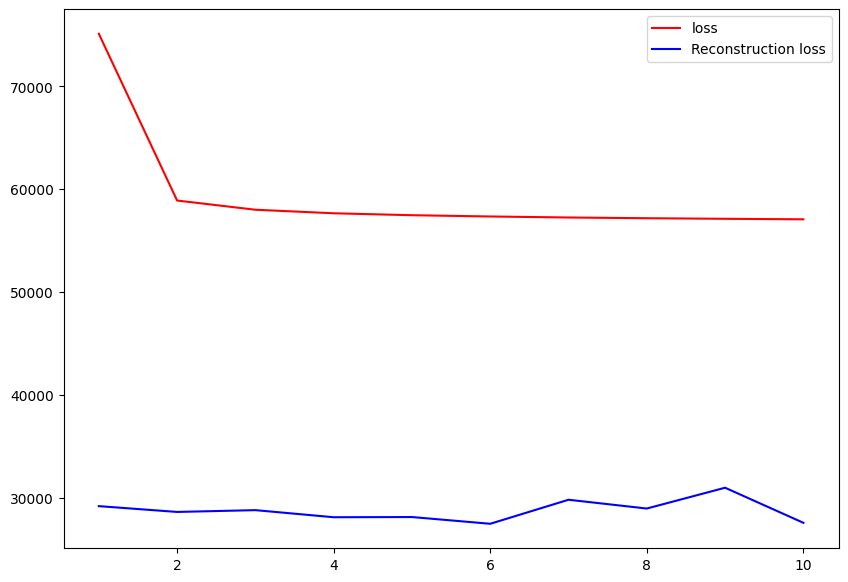

In [ ]:
n_epoch= range(1, len(loss) + 1)

figure = plt.figure(figsize=(10,7))



plt.plot(n_epoch, loss, label='loss', c='red')
plt.plot(n_epoch, recon, label='Reconstruction loss', c='blue')
plt.legend()

plt.show()

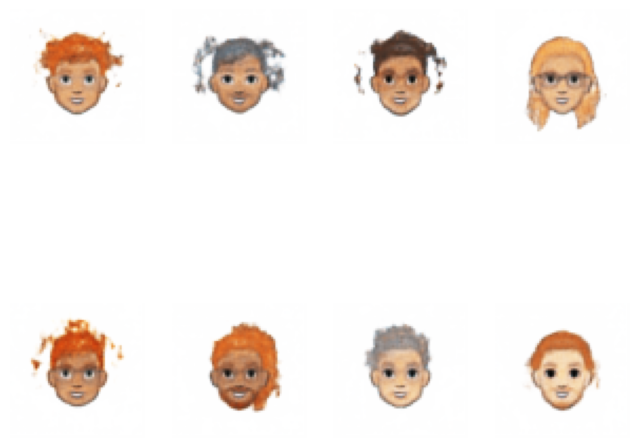

In [ ]:
def generate_new_images(model, n_face):
    model.eval()
    with torch.no_grad():
        z = torch.randn(n_face, 50).to(device)
        generated_images = model.decoder(z)


        return generated_images.cpu().numpy()

new_cartoon_faces = generate_new_images(model, 8)

figure = plt.figure(figsize=(8,7))
for i  in range(len(new_cartoon_faces)):
    figure.add_subplot(2, 4, i+1)
    plt.axis('off')
    plt.imshow(new_cartoon_faces[i].transpose(1, 2, 0))
plt.show()

# CVAE

In [ ]:
class FaceDataset2(Dataset):
    def __init__(self, image_paths , lables, transform=None):
        self.image_paths = image_paths
        self.labels = lables
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image , self.labels[idx]


transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])
image_paths = anime_face_paths[:int(len(anime_face_paths)/2)] + cartoon_face_paths[:int(len(cartoon_face_paths)/2)]
labels = [0 for _ in range(int(len(anime_face_paths)/2))] + [1 for _ in range(int(len(cartoon_face_paths)/2))]
dataset = FaceDataset2(image_paths , labels, transform=transform)
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
class CVAE(nn.Module):
  def __init__(self, n_z = 50, n_classes = 2):
    super(CVAE, self).__init__()
    self.n_z = n_z
    self.n_classes =n_classes
    original_dim = 64 * 64 * 3

    self.encoder_layers = torch.nn.Sequential(
      torch.nn.Conv2d(3 + n_classes, 16, kernel_size=3, stride=1, padding=1),
      torch.nn.BatchNorm2d(16),
      torch.nn.ReLU(),
      torch.nn.MaxPool2d(kernel_size=2, stride=2),
      torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
      torch.nn.BatchNorm2d(32),
      torch.nn.ReLU(),
      torch.nn.MaxPool2d(kernel_size=2, stride=2),
      torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
      torch.nn.BatchNorm2d(64),
      torch.nn.ReLU(),
      torch.nn.MaxPool2d(kernel_size=2, stride=2),
      torch.nn.Flatten()
    )


    self.mu = nn.Linear(8*8*64, n_z)
    self.log_sigma = nn.Linear(8*8*64, n_z)

    self.decoder_layers = torch.nn.Sequential(
      torch.nn.Linear(n_z + n_classes, 8*8*64) ,
      nn.Unflatten(1, (64, 8, 8)),
      torch.nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
      torch.nn.BatchNorm2d(32),
      torch.nn.ReLU(),
      torch.nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
      torch.nn.BatchNorm2d(16),
      torch.nn.ReLU(),
      torch.nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
      torch.nn.Sigmoid()
    )

  def encoder(self, x, y):
    y_one_hot = torch.nn.functional.one_hot(y, num_classes=self.n_classes).float()
    y_one_hot = y_one_hot.unsqueeze(2).unsqueeze(3)
    y_one_hot = y_one_hot.expand(-1, -1, x.shape[2], x.shape[3])
    x = torch.cat([x, y_one_hot], dim=1)
    x = self.encoder_layers(x)
    mu = self.mu(x)
    log_sigma = self.log_sigma(x)


    return mu, log_sigma

  def decoder(self, z, y):
    y_one_hot = torch.nn.functional.one_hot(y, num_classes=self.n_classes).float()
    z = torch.cat([z, y_one_hot], dim=1)
    x = self.decoder_layers(z)

    return x

  def sample_z(self, mu, log_sigma):
    std = torch.exp(0.5 * log_sigma)
    eps = torch.randn_like(std)
    z = mu + eps * std

    return z
  def forward(self, x, y):
    # Q(z|x) --encoder

    mu, log_sigma = self.encoder(x, y)
    # Sample z~Q(z|x)

    z = self.sample_z(mu, log_sigma)
    # P(X|z) --decoder
    output = self.decoder(z, y)

    return output , mu, log_sigma




In [ ]:
def VAE_loss(output, x, mu, log_sigma):
    recon = nn.BCELoss(reduction='sum')(output.reshape((output.shape[0], 64*64*3)), x.reshape((x.shape[0], 64*64*3)))
    kl = 0.5 * torch.sum(log_sigma.exp() + mu.pow(2) - 1 - log_sigma)
    return recon + kl , recon
loss_func = nn.CrossEntropyLoss()



def C_learn_one_step(model, optimizer, data, labels, device='cpu'):
      data = data.to(device)
      labels = labels.to(device)
      output, mu, log_sigma = model(data, labels)
      loss , recon= VAE_loss(output, data, mu, log_sigma)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      return  loss.item() , recon.item()


def CVAE_train(dataset, model, n_epoch = 5, m = 32,device='cpu'):
    history_loss=[]
    history_recon = []
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters())
    dataloader = DataLoader(dataset, batch_size=m, shuffle=True)
    for epoch in range(n_epoch):
          print(f'Epoch {epoch+1}')



          batch_losses, batch_recons=[], []
          model.train()
          for  data, labels in tqdm(dataloader):

              batch_loss, batch_recon = C_learn_one_step(model, optimizer, data, labels, device)
              batch_losses.append(batch_loss)
              batch_recons.append(batch_recon)
          recon = torch.mean(torch.tensor(batch_recon))
          loss = torch.mean(torch.tensor(batch_losses))
          history_loss.append(loss)
          history_recon.append(recon)

          print('loss: {loss:.4f}'.format(loss=loss))
          model.eval()
    return history_loss , history_recon

In [ ]:
model = CVAE()
CVAE_train(dataset, model)

100%|██████████| 1775/1775 [05:51<00:00,  5.05it/s]


Epoch [1/5], Loss: 156452.1373


100%|██████████| 1775/1775 [05:45<00:00,  5.13it/s]


Epoch [2/5], Loss: 145631.0188


100%|██████████| 1775/1775 [05:54<00:00,  5.01it/s]


Epoch [3/5], Loss: 144153.4027


100%|██████████| 1775/1775 [05:55<00:00,  4.99it/s]


Epoch [4/5], Loss: 143510.0265


100%|██████████| 1775/1775 [06:04<00:00,  4.87it/s]

Epoch [5/5], Loss: 143177.2498


[156452.13726232393,
 145631.01876320422,
 144153.40267385563,
 143510.02647227113,
 143177.24982614437]

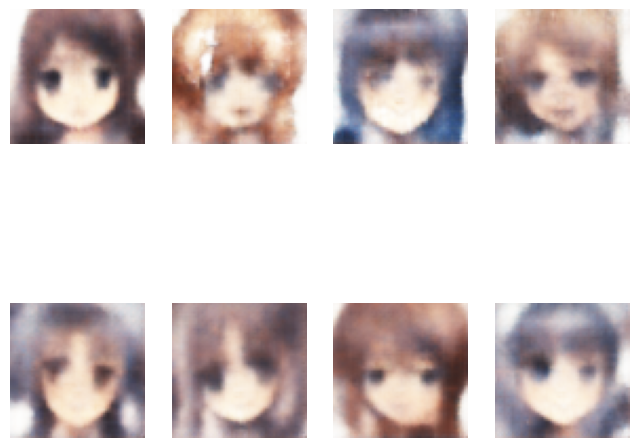

In [ ]:
def generate_new_images_with_class(model, n_images, l_class):
    model.eval()
    with torch.no_grad():
        z = torch.randn(n_images, 50).to(device)
        labels = torch.tensor([l_class] * n_images).to(device)
        generated_images = model.decoder(z, labels)
        return generated_images.cpu().numpy()
model = model.to(device)
c_new_anime_faces = generate_new_images_with_class(model, 8, 0)

figure = plt.figure(figsize=(8,7))
for i  in range(len(c_new_anime_faces)):
    figure.add_subplot(2, 4, i+1)
    plt.axis('off')
    plt.imshow(c_new_anime_faces[i].transpose(1, 2, 0))
plt.show()

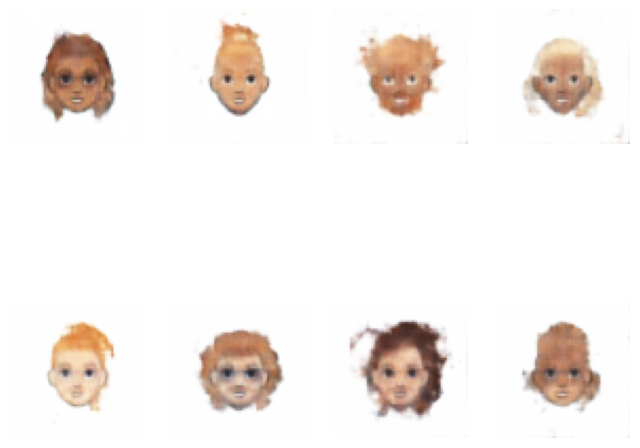

In [ ]:
c_new_cartoon_faces = generate_new_images_with_class(model, 8, 1)

figure = plt.figure(figsize=(8,7))
for i  in range(len(c_new_anime_faces)):
    figure.add_subplot(2, 4, i+1)
    plt.axis('off')
    plt.imshow(c_new_cartoon_faces[i].transpose(1, 2, 0))
plt.show()

#VQ-VAE

In [27]:
class VectorQuantizer(nn.Module):
    def __init__(self, K, D, beta):
        super(VectorQuantizer, self).__init__()
        self.K = K
        self.D = D
        self.beta = beta

        self.embeddings = nn.Embedding(K, D)
        self.embeddings.weight.data.uniform_(-1 / K, 1 / K)

    def forward(self, inputs):
        inputs = inputs.view(-1, self.D)

        distances = (torch.sum(inputs**2, dim=1, keepdim=True)  + torch.sum(self.embeddings.weight**2, dim=1)- 2 * torch.matmul(inputs, self.embeddings.weight.t()))


        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.size(0), self.K, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)


        quantized = torch.matmul(encodings, self.embeddings.weight).view(inputs.size())


        e_latent_loss = torch.nn.functional.mse_loss(quantized.detach(), inputs)
        q_latent_loss = torch.nn.functional.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self.beta * e_latent_loss

        z_q = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return loss, z_q.view_as(inputs)
class VQVAE(nn.Module):
    def __init__(self, n_z=50, K=512, D=64 , beta=0.25):
        super(VQVAE, self).__init__()
        self.n_z = n_z
        self.K = K
        self.D = D

        self.encoder_layers = torch.nn.Sequential(
            torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(64, D, kernel_size=1, stride=1),
        )

        self.vq_layer = VectorQuantizer(K, D, beta)

        self.decoder_layers = torch.nn.Sequential(
            nn.ConvTranspose2d(D, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            torch.nn.Sigmoid()
        )



    def forward(self, x):
        z_e = self.encoder_layers(x)
        loss, quantized = self.vq_layer(z_e)
        output = self.decoder_layers(quantized.reshape((-1,64,8,8)))
        return output , loss


def learn_one_step(model, optimizer, data, device):
      data = data.to(device)
      optimizer.zero_grad()
      print("nima")
      output, vq_loss = model(data)
      recon = torch.nn.functional.mse_loss(output, data)
      loss = recon + vq_loss
      loss.backward()
      optimizer.step()
      return loss.item(), recon.item()


def VQVAE_train(dataset, model, n_epoch=10, m=32):
    history_loss = []
    history_recon = []
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    dataloader = DataLoader(dataset, batch_size=m, shuffle=True)
    for epoch in range(n_epoch):
        print(f'Epoch {epoch+1}')
        batch_losses, batch_recons = [], []
        model.train()
        for i, data in enumerate(tqdm(dataloader)):
            batch_loss, batch_recon = learn_one_step(model, optimizer, data, device)
            batch_losses.append(batch_loss)
            batch_recons.append(batch_recon)
        recon = torch.mean(torch.tensor(batch_recons))
        loss = torch.mean(torch.tensor(batch_losses))
        history_loss.append(loss)
        history_recon.append(recon)
        print(f'loss: {loss:.4f}')
        model.eval()
    return history_loss, history_recon


In [40]:
import torch.nn.functional as F
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost

        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)
        self.embeddings.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)

    def forward(self, inputs):

        inputs = inputs.view(-1, self.embedding_dim)


        distances = (torch.sum(inputs**2, dim=1, keepdim=True)
                     + torch.sum(self.embeddings.weight**2, dim=1)
                     - 2 * torch.matmul(inputs, self.embeddings.weight.t()))


        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.size(0), self.num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)


        quantized = torch.matmul(encodings, self.embeddings.weight).view(inputs.size())


        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return loss, quantized.view_as(inputs), perplexity, encodings

class VQVAE(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VQVAE, self).__init__()
        self.embedding_dim = embedding_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, embedding_dim, kernel_size=1)
        )

        self.vq_layer = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embedding_dim, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z_e = self.encoder(x)
        # print(z_e.shape)
        loss, quantized, perplexity, _ = self.vq_layer(z_e)
        # print(quantized.shape)
        x_recon = self.decoder(quantized.reshape((-1,64,8,8)))  # تغییر شکل quantized
        # print(x_recon.shape)
        return x_recon, loss

def train_vqvae(dataloader, model, epochs=10):
    recon =[]
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_recon = 0.0
        for data in tqdm(dataloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, vq_loss = model(data)
            recon_loss = F.mse_loss(recon_batch, data)
            loss = recon_loss + vq_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_recon += recon_loss.item()
        # print(running_loss)

        avg_loss = running_loss / len(dataloader.dataset)
        avg_recon = running_recon / len(dataloader.dataset)
        recon.append(avg_recon)
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")
    return recon

In [41]:
vqvae_model = VQVAE(num_embeddings=512, embedding_dim=64, commitment_cost=0.25).to(device)
dataloader = DataLoader(anime_dataset, batch_size=32, shuffle=True)
train_vqvae(dataloader, vqvae_model, epochs=10)

100%|██████████| 1987/1987 [01:04<00:00, 30.61it/s]


Epoch [1/10], Loss: 0.0090


100%|██████████| 1987/1987 [01:04<00:00, 30.68it/s]


Epoch [2/10], Loss: 0.0054


100%|██████████| 1987/1987 [01:04<00:00, 30.70it/s]


Epoch [3/10], Loss: 0.0046


100%|██████████| 1987/1987 [01:04<00:00, 30.85it/s]


Epoch [4/10], Loss: 0.0041


100%|██████████| 1987/1987 [01:04<00:00, 30.71it/s]


Epoch [5/10], Loss: 0.0038


100%|██████████| 1987/1987 [01:04<00:00, 30.84it/s]


Epoch [6/10], Loss: 0.0036


100%|██████████| 1987/1987 [01:04<00:00, 31.02it/s]


Epoch [7/10], Loss: 0.0036


100%|██████████| 1987/1987 [01:04<00:00, 30.79it/s]


Epoch [8/10], Loss: 0.0035


100%|██████████| 1987/1987 [01:04<00:00, 30.95it/s]


Epoch [9/10], Loss: 0.0035


100%|██████████| 1987/1987 [01:04<00:00, 30.93it/s]

Epoch [10/10], Loss: 0.0034


[0.0009195417840604299,
 0.0007035436703412752,
 0.0006254106177188369,
 0.0005838189809145414,
 0.0005567145096439209,
 0.0005384597915903754,
 0.0005278750731023189,
 0.0005197313024393506,
 0.0005131044246834793,
 0.0005072125453848594]

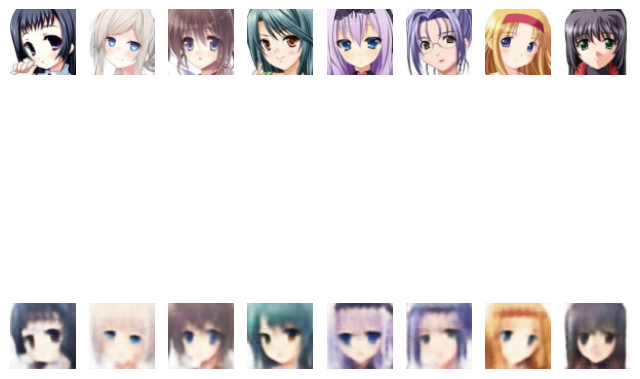

In [54]:
def show_reconstructed_images(model, dataloader, n_images):
    model.eval()
    with torch.no_grad():
        data_iter = iter(dataloader)
        images = next(data_iter)
        images = images[:n_images].to(device)
        recon_images, _ = model(images)
        recon_images = recon_images.cpu().numpy()

        fig, axes = plt.subplots(2, n_images, figsize=(8, 7))
        for i in range(n_images):
            axes[0, i].imshow(images[i].cpu().permute(1, 2, 0))
            axes[0, i].axis('off')
            axes[1, i].imshow(recon_images[i].transpose(1, 2, 0))
            axes[1, i].axis('off')
        plt.show()
show_reconstructed_images(vqvae_model, dataloader, n_images=8)

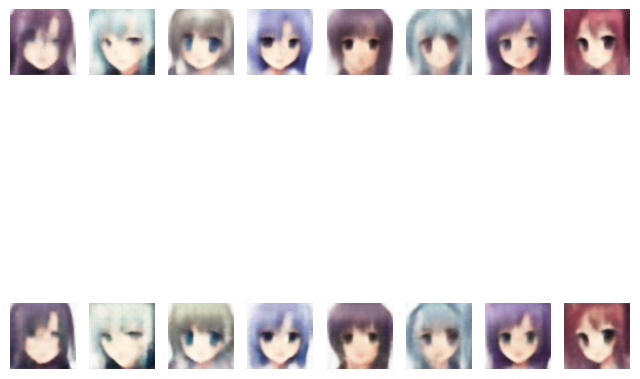

In [53]:
model.eval()
fig, axes = plt.subplots(2, 8, figsize=(8, 7))
def numpy_to_tensor(image, device):

    tensor = torch.from_numpy(image).unsqueeze(0).float()
    tensor = tensor.to(device)
    return tensor
with torch.no_grad():
        for i in range(8):
            image_tensor = numpy_to_tensor(new_anime_faces[i], device)
            axes[0, i].imshow(new_anime_faces[i].transpose(1, 2, 0))
            axes[0, i].axis('off')
            # Pass the tensor through the model
            recon_images, _= vqvae_model(image_tensor)
            # Convert the output tensor back to numpy array
            recon_images = recon_images.squeeze(0).permute(1, 2, 0).cpu().numpy()
            axes[1, i].imshow(recon_images)
            axes[1, i].axis('off')

plt.show()